# Inflation of a hyperelastic balloon

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/adtzlr/felupe-web/main?urlpath=git-pull%3Frepo%3Dhttps%253A%252F%252Fgithub.com%252Fadtzlr%252Ffelupe%26urlpath%3Dlab%252Ftree%252Ffelupe%252Fdocs%252Fexamples%252Finflation.ipynb%26branch%3Dmain)

```{admonition} Numeric continuation of a hyperelastic balloon under inner pressure.
* use FElupe with contique

* plot force-displacement curve
```

With the help of [contique](https://github.com/adtzlr/contique) (install with `pip install contique`) it is possible to apply a numerical parameter continuation algorithm on any system of equilibrium equations. This advanced tutorial demonstrates the usage of FElupe in conjunction with contique. The unstable inflation of a rectangular hyperelastic balloon demonstrates this powerful approach.

In [ ]:
import numpy as np
import felupe as fem
import contique

mesh = fem.Cube(b=(25, 25, 1), n=(11, 11, 2))
region = fem.RegionHexahedron(mesh)
field = fem.FieldContainer([fem.Field(region, dim=3)])
bounds = fem.dof.symmetry(field[0], axes=(True, True, False))
bounds["fix-z"] = fem.Boundary(field[0], fx=25, fy=25, mode="or", skip=(1, 1, 0))
dof0, dof1 = fem.dof.partition(field, bounds)

umat = fem.NeoHooke(mu=1)
solid = fem.SolidBodyNearlyIncompressible(umat, field, bulk=5000)

region_for_pressure = fem.RegionHexahedronBoundary(mesh, mask=(mesh.points[:, 2] == 0))
field_for_pressure = fem.FieldContainer([fem.Field(region_for_pressure, dim=3)])

pressure = fem.SolidBodyPressure(field_for_pressure)

In [ ]:
def fun(x, lpf, *args):
    field[0].values.ravel()[dof1] = x
    pressure.update(lpf)
    return fem.tools.fun([solid, pressure], field)[dof1]


def dfundx(x, lpf, *args):
    field[0].values.ravel()[dof1] = x
    pressure.update(lpf)
    K = fem.tools.jac([solid, pressure], field)
    return fem.solve.partition(field, K, dof1, dof0)[2]


def dfundl(x, lpf, *args):
    field[0].values.ravel()[dof1] = x
    pressure.update(1)
    return fem.tools.fun([pressure], field)[dof1]

In [ ]:
Res = contique.solve(
    fun=fun,
    jac=[dfundx, dfundl],
    x0=field[0][dof1],
    lpf0=0,
    dxmax=1e-3,
    dlpfmax=1e-6,
    high=100,
    maxsteps=1000,
    rebalance=True,
)
X = np.array([res.x for res in Res])

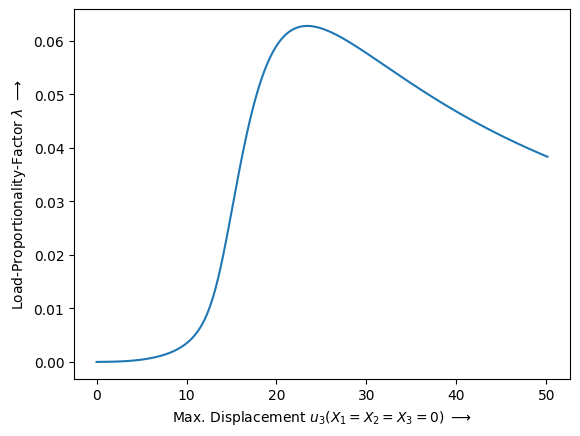

In [13]:
import matplotlib.pyplot as plt

plt.plot(X[:, 2], X[:, -1])
plt.xlabel(r"Max. Displacement $u_3(X_1=X_2=X_3=0)$ $\longrightarrow$")
plt.ylabel(r"Load-Proportionality-Factor $\lambda$ $\longrightarrow$");

In [ ]:
view = fem.View(field, solid)
view.mesh.cell_data.keys()

In [ ]:
view.plot("Principal Values of Cauchy Stress").show(screenshot="images/inflation.png")

![inflation](images/inflation.png)